In [20]:
import os
import numpy as np
import pandas as pd
from typing import List
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="notebook", 
              style="white")

import string
import re
from unidecode import unidecode
import nltk
nltk.download("stopwords")
from collections import Counter

from sklearn.model_selection import train_test_split

import gzip
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (classification_report,
                             accuracy_score)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
path = "/kaggle/input/sentiment-analysis-for-financial-news"
file_path = os.path.join(path, "all-data.csv")
df = pd.read_csv(file_path, encoding="latin-1",
                 names=["sentiment", "news"],
                 header=None)
df.head()

,sentiment,news
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [3]:
df.shape

(4846, 2)

In [4]:
# Check NaNs
df.isnull().sum()

sentiment    0
news         0
dtype: int64

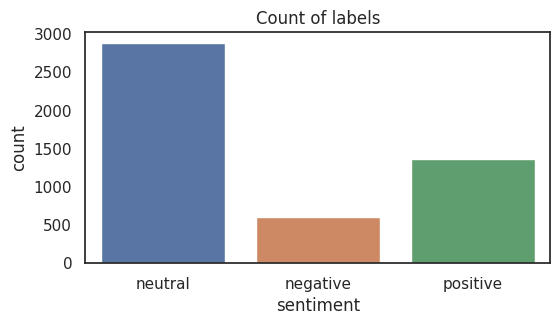

In [5]:
# Check labels
_, ax = plt.subplots(figsize=(6, 3))

sns.countplot(df, x="sentiment", ax=ax)
ax.set_title("Count of labels")
plt.show()

# Text preprocessing

In [6]:
stop_words = nltk.corpus.stopwords.words("english")
stop_words = list(set(stop_words))

def preprocess_text(text):
    """
    Text preprocessing function.
    """
    global stop_words
    
    # Apply lowercase
    text = text.lower()
    
    # Remove 's and s'
    text = re.sub(pattern=r"'s", repl="", string=text)
    text = re.sub(pattern=r"s'", repl="", string=text)
    
    # Remove accents
    text = unidecode(text)
    
    # Remove urls
    # Ref https://regex101.com/r/fO6mX3/2
    url_pattern = r"((?<=[^a-zA-Z0-9])(?:https?\:\/\/|[a-zA-Z0-9]{1,}\.{1}|\b)(?:\w{1,}\.{1}){1,5}(?:com|org|edu|gov|uk|net|ca|de|jp|fr|au|us|ru|ch|it|nl|se|no|es|mil|iq|io|ac|ly|sm){1}(?:\/[a-zA-Z0-9]{1,})*)"
    text = re.sub(url_pattern, "", text)
    
    # Remove numbers
    text = re.sub(r"\d+", "", text)
    
    # Remove extra spaces
    text = re.sub(r"\s+", " ", text)
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove stop words
    text = [w for w in text.split(" ") if w not in stop_words]
    
    # Remove extra spaces
    text = [w.strip() for w in text if len(w)]
    
    # Re-join text
    text = " ".join(text)
    
    return text

sample_text = """
SAmplE téxt's 123.,.:~ 
http://test.com
"""
preprocess_text(sample_text)

'sample text'

In [7]:
# Apply text preprocess
df["news_preprocess"] = df["news"].apply(lambda x: preprocess_text(x))
df.head()

,sentiment,news,news_preprocess
0,neutral,"According to Gran , the company has no plans t...",according gran company plans move production r...
1,neutral,Technopolis plans to develop in stages an area...,technopolis plans develop stages area less squ...
2,negative,The international electronic industry company ...,international electronic industry company elco...
3,positive,With the new production plant the company woul...,new production plant company would increase ca...
4,positive,According to the company 's updated strategy f...,according company updated strategy years baswa...


In [34]:
# Most frequent words per label
counters = {}
for label in ["positive", "neutral", "negative"]:
    df_label = df.loc[df["sentiment"] == label]
    counter = Counter()
    for sent in df_label["news_preprocess"].tolist():
        counter.update(sent.split(" "))
    counters[label] = counter

In [ ]:
break

In [36]:
counters["negative"]

Counter({'eur': 400,
         'mn': 237,
         'profit': 156,
         'net': 104,
         'company': 100,
         'finnish': 99,
         'sales': 98,
         'operating': 97,
         'period': 88,
         'quarter': 79,
         'million': 78,
         'said': 77,
         'year': 75,
         'loss': 69,
         'compared': 68,
         'decreased': 68,
         'mln': 68,
         'first': 57,
         'oyj': 51,
         'fell': 46,
         'corresponding': 46,
         'finland': 43,
         'euro': 40,
         'group': 37,
         'result': 35,
         'half': 34,
         'today': 33,
         'pct': 32,
         'helsinki': 32,
         'share': 32,
         'earlier': 30,
         'lower': 29,
         'hel': 28,
         'third': 27,
         'per': 26,
         'totalled': 26,
         'omx': 23,
         'market': 22,
         'employees': 20,
         'personnel': 19,
         'items': 19,
         'due': 18,
         'usd': 18,
         'second': 18,
      

In [8]:
# Encode labels
sent_labels = {
    0: "neutral",
    -1: "negative",
    1: "positive"
}
df["sentiment"] = df["sentiment"].map({v: k for k, v in sent_labels.items()})
df.head()

,sentiment,news,news_preprocess
0,0,"According to Gran , the company has no plans t...",according gran company plans move production r...
1,0,Technopolis plans to develop in stages an area...,technopolis plans develop stages area less squ...
2,-1,The international electronic industry company ...,international electronic industry company elco...
3,1,With the new production plant the company woul...,new production plant company would increase ca...
4,1,According to the company 's updated strategy f...,according company updated strategy years baswa...


In [9]:
# Train validation split
train, val = train_test_split(df, test_size=.2, random_state=123)

X_train = train["news_preprocess"].tolist()
y_train = train["sentiment"].tolist()

X_val = val["news_preprocess"].tolist()
y_val = val["sentiment"].tolist()

In [10]:
def ncd(x1: str, x2: str) -> float:
    """
    Returns the Normalized Compression Distance (NCD)
    between two sequences.
    
    Args:
        x1 (str): First sequence.
        x2 (str): Second sequence.
        
    Returns:
        ncd (float): Normalized compression distance between x1 and x2.
    """
    x1_compressed = len(gzip.compress(x1.encode()))
    x2_compressed = len(gzip.compress(x2.encode()))
    x1x2_compressed = len(gzip.compress(" ".join([x1, x2]).encode()))
    return (x1x2_compressed - min(x1_compressed, x2_compressed)) / max(x1_compressed, x2_compressed)

x1 = "Test string 1"
x2 = "Another string used for testing."
print(ncd(x1, x1))
print(ncd(x2, x2))
print(ncd(x1, x2))
print(ncd(x2, x1))

0.12121212121212122
0.0784313725490196
0.47058823529411764
0.47058823529411764


In [11]:
# Apply NCD to the training data
train_ncd = []
for i in tqdm(range(len(X_train))):
    ncd_ij = []
    for j in range(len(X_train)):
        ncd_ij.append(ncd(X_train[i], X_train[j]))
    train_ncd.append(ncd_ij)

100%|██████████| 3876/3876 [15:35<00:00,  4.14it/s]


In [12]:
train_ncd[0][:10]

[0.07142857142857142,
 0.5656565656565656,
 0.4868421052631579,
 0.6460176991150443,
 0.5308641975308642,
 0.5581395348837209,
 0.625,
 0.6330275229357798,
 0.44285714285714284,
 0.6]

In [13]:
# Train a KNN classifier
clf = KNeighborsClassifier()
clf.fit(train_ncd, y_train)

KNeighborsClassifier()

In [14]:
# Run validation
ncd_val = []
for i in tqdm(range(len(X_val))):
    ncd_ij = []
    for j in range(len(X_train)):
        ncd_ij.append(ncd(X_val[i], X_train[j]))
    ncd_val.append(ncd_ij)

100%|██████████| 970/970 [03:55<00:00,  4.11it/s]


In [17]:
# Check performance
y_pred = clf.predict(ncd_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

          -1       0.37      0.27      0.31       122
           0       0.65      0.87      0.74       562
           1       0.48      0.21      0.29       286

    accuracy                           0.60       970
   macro avg       0.50      0.45      0.45       970
weighted avg       0.56      0.60      0.56       970



In [19]:
print(accuracy_score(y_val, y_pred))

0.6010309278350515
